### **Práctica 2 - Machine Learning III**

**Objetivo**: 
1. Analizar el conjunto de datos. 
2. Crear un sistema de recomendación de artistas para usuarios.
   
**Entregar**: Este cuaderno de jupyter con el trabajo hecho y comentado.

**Datos**: 

Los datos suministrados ya han sido procesados, limpiados y estructurados para simplificar su manejo y análisis. 

Para aquellos interesados en explorar y manipular el conjunto de datos original, así como entender la estructura, podéis descargarlo directamente aquí: 

https://grouplens.org/datasets/hetrec-2011/.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cornac
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN

C:\Users\Rocío\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

artists = pd.read_csv('./artists.dat', header=0, sep='\t')
user_tag_artist = pd.read_csv('./user_taggedartists.dat', header=0, sep='\t')
tags = pd.read_csv('tags.dat', header=0, sep='\t', encoding='latin-1')
users = pd.read_csv('user_artists.dat',header=0, sep='\t')


## EDA

In [3]:
artists.head()


,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [4]:
user_tag_artist.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [5]:
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [6]:
users.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [7]:
unique_artists = len(artists['id'].unique())
print('There are', unique_artists, 'unique artists in the dataset.')

unique_users = len(users['userID'].unique())
print('There are', unique_users, 'unique users in the dataset.')

There are 17632 unique artists in the dataset.
There are 1892 unique users in the dataset.


userID
2       50
1376    50
1388    50
1387    50
1386    50
        ..
2085     1
1758     1
615      1
1013     1
1731     1
Name: count, Length: 1892, dtype: int64


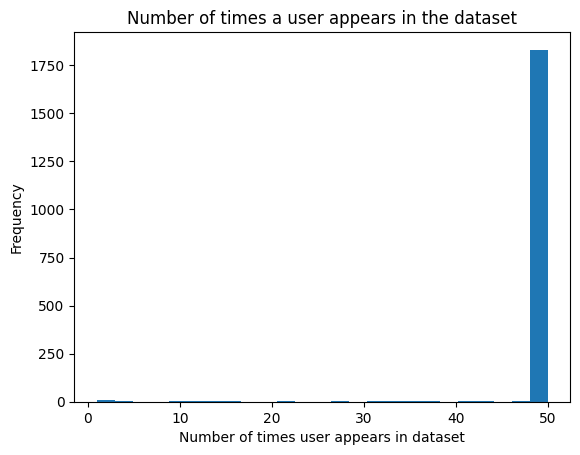

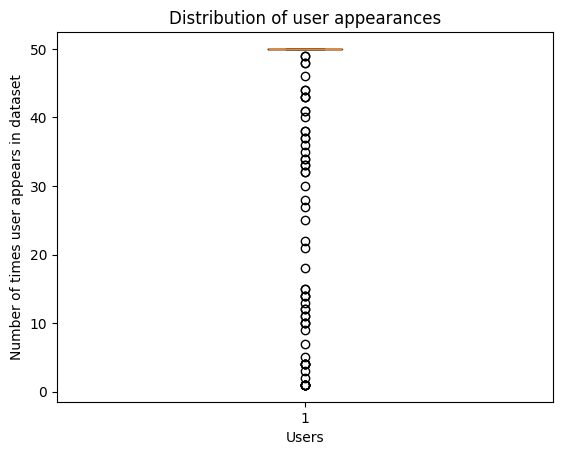

In [8]:
import matplotlib.pyplot as plt

user_artist_count = users['userID'].value_counts()

print(user_artist_count)

plt.hist(user_artist_count, bins=25)
plt.xlabel('Number of times user appears in dataset')
plt.ylabel('Frequency')
plt.title('Number of times a user appears in the dataset')
plt.show()

plt.boxplot(user_artist_count)
plt.xlabel('Users')
plt.ylabel('Number of times user appears in dataset')
plt.title('Distribution of user appearances')
plt.show()



Analizando esta distribución, consideramos apropiado eliminar outliers, centrando el modelo en usuarios con mas artistas esuchados

In [9]:
Q1 = user_artist_count.quantile(0.25)
Q3 = user_artist_count.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = user_artist_count[(user_artist_count < lower_bound) | (user_artist_count > upper_bound)]
percentage_of_outliers = (len(outliers) / len(user_artist_count))

percentage_of_outliers = round(percentage_of_outliers, 3)
print(str(percentage_of_outliers) + " of the data are outliers")

0.033 of the data are outliers


In [10]:
# Remove outliers
users = users[users['userID'].isin(user_artist_count[user_artist_count < upper_bound].index)]

In [11]:
top_artists = users.groupby('artistID')['weight'].sum()
# add the name of the artists to the top_artists series
top_artists = top_artists.reset_index()
top_artists = top_artists.merge(artists[['id', 'name']], left_on='artistID', right_on='id')
top_artists = top_artists.drop('id', axis=1)
top_artists = top_artists.sort_values('weight', ascending=False)
top_artists.head(10)



,artistID,weight,name
63,289,249303,Britney Spears
95,344,56571,Taylor Swift
15,89,45774,Lady Gaga
62,288,31489,Rihanna
9,67,23383,Madonna
10,72,17545,Depeche Mode
162,533,16138,Oasis
20,157,14311,Michael Jackson
66,292,12789,Christina Aguilera
133,461,8518,Miley Cyrus


En este apartado vemos que, una vez eliminados outliers, los artistas más escuchados se corresponden con los más populares de 2011. Hemos decidido eliminar a Britney Spears de la siguiente gráfica porque tiene un peso demasiado superior (5 veces más que el siguiente), y quita visibilidad a los mismos. Sin embargo, seguirá presente en los modelos.

In [12]:
#remove the artist with id 289 as 5 times larger than others
users_nobs = users[users['artistID'] != 289]

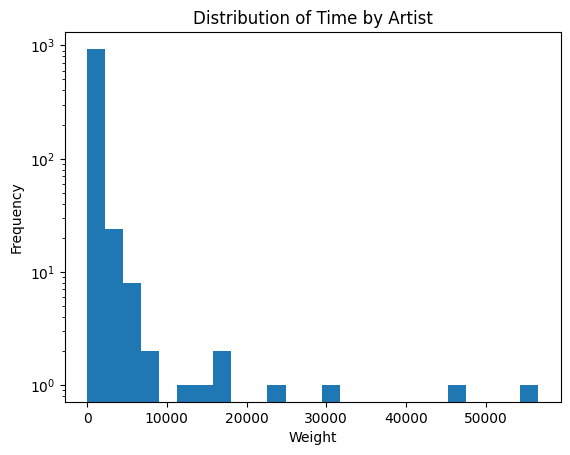

In [13]:
users_nobs.groupby('artistID')['weight'].sum().plot(kind='hist', bins=25)
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Distribution of Time by Artist')
plt.show()


## Sistema de Recomendacion

Hemos hecho el siguiente modelo de recomendación memory-based como prueba para ver el comportamiento con este tipo de datos. Además, podremos aprovechar la función para recomendar para nuestro modelo implícito.

In [15]:
users.head()

,userID,artistID,weight
1600,35,186,1
1601,35,212,4
1602,35,444,1
1603,35,920,1
1604,35,964,1


In [16]:
def userknn_cornac(df:pd.DataFrame):

  #df = df.astype({'userID':object, 'artistID':object})
  records = df.to_records(index=False)
  result = list(records)

  K = 3  # number of nearest neighbors
  VERBOSE = False
  SEED = 42
  uknn_cosine = UserKNN(k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE)
  uknn_cosine_mc = UserKNN(k=K, similarity="cosine", mean_centered=True, name="UserKNN-Cosine-MC", verbose=VERBOSE)
  uknn_pearson = UserKNN(k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE)
  uknn_pearson_mc = UserKNN(k=K, similarity="pearson", mean_centered=True, name="UserKNN-Pearson-MC", verbose=VERBOSE)
  
  # Metrics
  rec_100 = cornac.metrics.Recall(k=100)
  rec_500 = cornac.metrics.Recall(k=500)
  prec_10 = cornac.metrics.Precision(k=10)
  rmse = cornac.metrics.RMSE()
  mae = cornac.metrics.MAE()
  
  ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
  cornac.Experiment(eval_method=ratio_split,
                    models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
                    metrics=[rec_100, rec_500, prec_10, rmse, mae],
                    ).run()
  
  userknn_models = {'uknn_cosine': uknn_cosine, 'uknn_cosine_mc': uknn_cosine_mc,
                'uknn_pearson': uknn_pearson, 'uknn_pearson_mc': uknn_pearson_mc}
  
  return userknn_models

userknn_models = userknn_cornac(users)


TEST:
...
                   |       MAE |      RMSE | Precision@10 | Recall@100 | Recall@500 | Train (s) | Test (s)
------------------ + --------- + --------- + ------------ + ---------- + ---------- + --------- + --------
UserKNN-Cosine     | 2584.6707 | 2957.4245 |       0.0161 |     0.2285 |     0.4097 |    0.3123 |   0.1954
UserKNN-Cosine-MC  | 1332.5383 | 1709.3279 |       0.0097 |     0.2608 |     0.4806 |    0.0141 |   0.1109
UserKNN-Pearson    | 1332.5383 | 1709.3279 |       0.0097 |     0.2608 |     0.4806 |    0.0147 |   0.1020
UserKNN-Pearson-MC | 1332.5383 | 1709.3279 |       0.0097 |     0.2608 |     0.4806 |    0.0069 |   0.1080



Nos quedamos con los resultados de RMSE y MAE que seremos capaz de reducir mucho en el sistema de recomendación implícito.

In [17]:
# Vemos que índice tiene asociado cada ID de usuario
model = userknn_models.get('uknn_pearson')
list(model.uid_map.items())[:5]

[(1290, 0), (510, 1), (408, 2), (1004, 3), (38, 4)]

In [18]:
import pandas as pd
def userRecomendations(UID, model, artists, TOPK=5):
  results = []
  prods = list(model.iid_map.keys())
  ids = list(model.iid_map.values())
  for i in range(len(model.iid_map)-1):
      results.append((prods[i], model.score(model.uid_map[UID], ids[i])))
  
  results = sorted(results, key=lambda x: x[1], reverse=True)
  
  df = pd.DataFrame(results, columns=['productID', 'weight'])
  return df.head(TOPK).merge(artists, left_on='productID', right_on='id')[['name', 'weight']]


userRecomendations(1290, model, artists)
# Al primer usuario del mapa parece gustarle Rihanna

,name,weight
0,Rihanna,26049.714025
1,Oasis,12945.155715
2,Depeche Mode,8028.155764
3,The Beatles,3417.155810
4,Muse,2474.155819


## Implicit

In [24]:

import sys
import cornac
from cornac.eval_methods import RatioSplit
from cornac.models import WMF
import tensorflow as tf

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 42
VERBOSE = False

System version: 3.11.8 | packaged by Anaconda, Inc. | (main, Feb 26 2024, 21:34:05) [MSC v.1916 64 bit (AMD64)]
Cornac version: 2.1
Tensorflow version: 2.16.1


Vamos a llevar a cabo una optimización de los hiperparámetros que le vamos a pasar al modelo. El valor de *a* y *b* los mantendremos constantes en 1 y 0.01, mientras que para los demás hiperparámetros probaremos distintas combinaciones y evaluaremos los resultados

In [25]:
param_grid = {
    "k": [10, 20, 30, 40, 50],
    "learning_rate": [0.001, 0.01, 0.1],
    "lambda_u": [0.001, 0.01],
    "lambda_v": [0.001, 0.01],
}

In [26]:
wmfs = []
for k in param_grid["k"]:
      for learning_rate in param_grid["learning_rate"]:
          for lambda_u in param_grid["lambda_u"]:
            for lambda_v in param_grid["lambda_v"]:
                wmf = WMF(k=k, max_iter=100, learning_rate=learning_rate, lambda_u=lambda_u, lambda_v=lambda_v, verbose=VERBOSE, seed=SEED, name=f"WMF(K={k}, learning_rate={learning_rate}, lambda_u={lambda_u}, lambda_v={lambda_v})")
                wmfs.append(wmf)

eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.MAE()
]

df = users.astype({'userID':object, 'artistID':object})
records = df.to_records(index=False)
result = list(records)

rs = RatioSplit(result, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=wmfs, metrics=eval_metrics).run()



TEST:
...
                                                               |      MAE |     RMSE | Train (s) | Test (s)
-------------------------------------------------------------- + -------- + -------- + --------- + --------
WMF(K=10, learning_rate=0.001, lambda_u=0.001, lambda_v=0.001) | 479.4458 | 726.2988 |    5.4052 |   0.0010
WMF(K=10, learning_rate=0.001, lambda_u=0.001, lambda_v=0.01)  | 479.4458 | 726.2988 |    0.9128 |   0.0010
WMF(K=10, learning_rate=0.001, lambda_u=0.01, lambda_v=0.001)  | 479.4458 | 726.2988 |    1.0250 |   0.0070
WMF(K=10, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01)   | 479.4458 | 726.2988 |    1.0509 |   0.0000
WMF(K=10, learning_rate=0.01, lambda_u=0.001, lambda_v=0.001)  | 469.7939 | 717.0199 |    1.0711 |   0.0097
WMF(K=10, learning_rate=0.01, lambda_u=0.001, lambda_v=0.01)   | 469.7939 | 717.0197 |    0.8691 |   0.0130
WMF(K=10, learning_rate=0.01, lambda_u=0.01, lambda_v=0.001)   | 469.8264 | 717.0520 |    1.0389 |   0.0010
WMF(K=10, learni

Aquí vemos una mejora clara respecto al sistema memory-based, reduciendo el RMSE aproximadamente a la mitad. Para escoger el mejor modelo, vemos que el mejor MAE coincide con el mejor RMSE (diferencias lineales vs cuadráticas) y escogemos ese. Tiene los parámetros: (K=10, learning_rate=0.1, lambda_u=0.001, lambda_v=0.001). Podemos reciclar la función de recomendación anterior para este caso.

In [32]:
model = wmfs[8]
print(model.name)
userRecomendations(701, model, artists)
# A este usuario le recomienda Britney Spears, poco sorprendente dada su dominancia en los datos

WMF(K=10, learning_rate=0.1, lambda_u=0.001, lambda_v=0.001)


,name,weight
0,Britney Spears,799.830200
1,Rihanna,776.881042
2,Lady Gaga,655.595642
3,Katy Perry,577.198975
4,Vanessa Hudgens,558.816833
